# Meltingtank
## 1. 데이터 확인

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import tensorflow as tf
#import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# 여기서는 버전이 1.19.5 / 2.4.0 사용되어야함
# pip install numpy==1.19.5
print("numpy 버전 : ", np.__version__)
print("tensorflow 버전 : ", tf.__version__)

numpy 버전 :  1.19.5
tensorflow 버전 :  2.4.0


In [3]:
df = pd.read_csv('data/melting_tank.csv')
df

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,489,116,631,3.19,OK
1,2020-03-04 0:00,1,433,78,609,3.19,OK
2,2020-03-04 0:00,2,464,154,608,3.19,OK
3,2020-03-04 0:00,3,379,212,606,3.19,OK
4,2020-03-04 0:00,4,798,1736,604,3.21,OK
...,...,...,...,...,...,...,...
835195,2020-04-30 23:59,835195,755,1743,318,3.21,OK
835196,2020-04-30 23:59,835196,385,206,317,3.19,OK
835197,2020-04-30 23:59,835197,465,148,316,3.20,OK
835198,2020-04-30 23:59,835198,467,0,314,3.19,OK


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835200 entries, 0 to 835199
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   STD_DT       835200 non-null  object 
 1   NUM          835200 non-null  int64  
 2   MELT_TEMP    835200 non-null  int64  
 3   MOTORSPEED   835200 non-null  int64  
 4   MELT_WEIGHT  835200 non-null  int64  
 5   INSP         835200 non-null  float64
 6   TAG          835200 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 44.6+ MB


In [5]:
df['TAG'].value_counts()

OK    658133
NG    177067
Name: TAG, dtype: int64

## 2. EDA

In [6]:
df['STD_DT'] = pd.to_datetime(df['STD_DT'], format='%Y-%m-%d %H:%M:%S')
df = df.set_index('STD_DT')
df

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
STD_DT,,,,,,
2020-03-04 00:00:00,0,489,116,631,3.19,OK
2020-03-04 00:00:00,1,433,78,609,3.19,OK
2020-03-04 00:00:00,2,464,154,608,3.19,OK
2020-03-04 00:00:00,3,379,212,606,3.19,OK
2020-03-04 00:00:00,4,798,1736,604,3.21,OK
...,...,...,...,...,...,...
2020-04-30 23:59:00,835195,755,1743,318,3.21,OK
2020-04-30 23:59:00,835196,385,206,317,3.19,OK
2020-04-30 23:59:00,835197,465,148,316,3.20,OK


In [7]:
df['TAG'] = df['TAG'].replace('OK', 1)
df['TAG'] = df['TAG'].replace('NG', 0)
df['TAG'].value_counts()

1    658133
0    177067
Name: TAG, dtype: int64

In [8]:
corr = df.corr()
corr

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
NUM,1.000000,0.000188,-0.000050,0.080079,-0.000524,0.086698
MELT_TEMP,0.000188,1.000000,0.944929,-0.000336,0.916295,0.310586
MOTORSPEED,-0.000050,0.944929,1.000000,0.000123,0.887813,0.264693
MELT_WEIGHT,0.080079,-0.000336,0.000123,1.000000,-0.000005,-0.012084
INSP,-0.000524,0.916295,0.887813,-0.000005,1.000000,0.272580
TAG,0.086698,0.310586,0.264693,-0.012084,0.272580,1.000000


<AxesSubplot:>

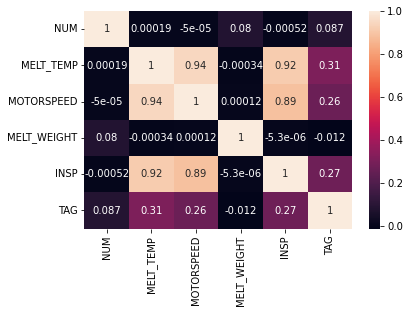

In [9]:
sns.heatmap(corr, annot=True)

## 3. 학습

In [10]:
from sklearn.model_selection import train_test_split

X = df[['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP']]
y = df['TAG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(584640, 4)
(250560, 4)
(584640,)
(250560,)


### 3-1. XGB Classifier

In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

xgb_accu = accuracy_score(y_test, xgb_pred)

print("Accuracy:", xgb_accu)
print(classification_report(y_test, xgb_pred))

[11:25:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.7958413154533844
              precision    recall  f1-score   support

           0       0.67      0.07      0.13     53142
           1       0.80      0.99      0.88    197418

    accuracy                           0.80    250560
   macro avg       0.74      0.53      0.51    250560
weighted avg       0.77      0.80      0.72    250560



### 3-2. LSTM

In [12]:
def make_dataset(data, label, window):
    X = []
    y = []
    
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(label[i+window])
    
    return np.array(X), np.array(y)

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)

In [14]:
train_feature, train_label = make_dataset(train_scaled, y_train, 10)
test_feature, test_label = make_dataset(test_scaled, y_test, 10)

In [15]:
print(train_feature.shape)
print(train_label.shape)
print(test_feature.shape)
print(test_label.shape)

(584630, 10, 4)
(584630,)
(250550, 10, 4)
(250550,)


In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.3)

X_train.shape, X_valid.shape

((409241, 10, 4), (175389, 10, 4))

### Model Build

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing import sequence
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

In [18]:
model = Sequential()
model.add(LSTM(50, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='tanh', 
               return_sequences=False)
          )
model.add(Dense(1, activation='sigmoid'))
model.summary()

2021-09-13 11:25:38.080128: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-13 11:25:38.080401: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11000     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['sparse_categorical_accuracy']) 

In [20]:
# 아래와같이 compile, fit한 파일은 베스트만 뽑아서 따로 저장하고 불러와서 사용하는 경우에는 metrics에 sparse를 사용할 필요가 없음
# model.compile(loss='binary_crossentropy', 
#               optimizer='adam', 
#               metrics=['accuracy'],) 

# early_stop = EarlyStopping(monitor='val_loss', patience=5)
# filename = os.path.join('tmp_checkpoint.h5')
# checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=0, 
#                              save_best_only=True, mode='auto')

# history = model.fit(X_train, y_train, 
#                     epochs=200, 
#                     batch_size=256,
#                     validation_data=(X_valid, y_valid),
#                     callbacks=[early_stop, checkpoint])

# model.load_weights(filename)

In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_valid, y_valid), callbacks=[early_stop])

Epoch 1/100


2021-09-13 11:25:38.576749: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


1599/1599 [==============================] - 36s 21ms/step - loss: 0.5252 - sparse_categorical_accuracy: 0.2117 - val_loss: 0.5190 - val_sparse_categorical_accuracy: 0.2139
Epoch 2/100
1599/1599 [==============================] - 33s 21ms/step - loss: 0.5139 - sparse_categorical_accuracy: 0.2098 - val_loss: 0.5212 - val_sparse_categorical_accuracy: 0.2139
Epoch 3/100
1599/1599 [==============================] - 32s 20ms/step - loss: 0.5141 - sparse_categorical_accuracy: 0.2099 - val_loss: 0.5191 - val_sparse_categorical_accuracy: 0.2139
Epoch 4/100
1599/1599 [==============================] - 31s 19ms/step - loss: 0.5160 - sparse_categorical_accuracy: 0.2115 - val_loss: 0.5192 - val_sparse_categorical_accuracy: 0.2139
Epoch 5/100
1599/1599 [==============================] - 31s 19ms/step - loss: 0.5147 - sparse_categorical_accuracy: 0.2104 - val_loss: 0.5191 - val_sparse_categorical_accuracy: 0.2139
Epoch 6/100
1599/1599 [==============================] - 30s 18ms/step - loss: 0.5160 -

In [22]:
model.evaluate(test_feature, test_label)

7830/7830 [==============================] - 18s 2ms/step - loss: 0.5169 - sparse_categorical_accuracy: 0.2121


[0.5168583393096924, 0.21209339797496796]

In [23]:
# lstm_preds = model.predict(test_feature).argmax(axis=-1)
lstm_preds = model.predict_classes(test_feature)
lstm_preds

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [24]:
accuracy = model.evaluate(test_feature, test_label)

print("Accuracy:", accuracy)
print(classification_report(test_label, lstm_preds))

7830/7830 [==============================] - 17s 2ms/step - loss: 0.5169 - sparse_categorical_accuracy: 0.2121
Accuracy: [0.5168583393096924, 0.21209339797496796]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     53140
           1       0.79      1.00      0.88    197410

    accuracy                           0.79    250550
   macro avg       0.39      0.50      0.44    250550
weighted avg       0.62      0.79      0.69    250550



### 3-3. LSTM + SMOTE

In [25]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [26]:
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)

train_feature, train_label = make_dataset(train_scaled, y_train, 10)
test_feature, test_label = make_dataset(test_scaled, y_test, 10)

print(train_feature.shape)
print(train_label.shape)
print(test_feature.shape)
print(test_label.shape)

(921420, 10, 4)
(921420,)
(250550, 10, 4)
(250550,)


In [27]:
# train, validation set 생성
X_train, X_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.3)

X_train.shape, X_valid.shape

((644994, 10, 4), (276426, 10, 4))

In [28]:
mo = Sequential()
mo.add(LSTM(50, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='tanh', 
               return_sequences=False)
          )
mo.add(Dense(1, activation='sigmoid'))
mo.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                11000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________


In [29]:
mo.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy']) 

In [30]:
mo.fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_valid, y_valid), callbacks=[early_stop])

Epoch 1/100
2520/2520 [==============================] - 45s 17ms/step - loss: 0.4514 - accuracy: 0.8037 - val_loss: 0.4141 - val_accuracy: 0.8313
Epoch 2/100
2520/2520 [==============================] - 45s 18ms/step - loss: 0.4128 - accuracy: 0.8323 - val_loss: 0.4120 - val_accuracy: 0.8325
Epoch 3/100
2520/2520 [==============================] - 47s 19ms/step - loss: 0.4097 - accuracy: 0.8334 - val_loss: 0.4087 - val_accuracy: 0.8334
Epoch 4/100
2520/2520 [==============================] - 49s 19ms/step - loss: 0.4067 - accuracy: 0.8347 - val_loss: 0.4058 - val_accuracy: 0.8346
Epoch 5/100
2520/2520 [==============================] - 45s 18ms/step - loss: 0.4052 - accuracy: 0.8342 - val_loss: 0.4039 - val_accuracy: 0.8351
Epoch 6/100
2520/2520 [==============================] - 48s 19ms/step - loss: 0.4043 - accuracy: 0.8351 - val_loss: 0.4034 - val_accuracy: 0.8356
Epoch 7/100
2520/2520 [==============================] - 50s 20ms/step - loss: 0.4029 - accuracy: 0.8353 - val_loss: 0

In [31]:
mo.evaluate(test_feature, test_label)

7830/7830 [==============================] - 13s 2ms/step - loss: 0.5341 - accuracy: 0.7757


[0.5341236591339111, 0.7757334113121033]

In [32]:
smote_preds = mo.predict_classes(test_feature)
smote_preds

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [33]:
np.unique(smote_preds)

array([0, 1], dtype=int32)

In [34]:
print("Accuracy:", accuracy)
print(classification_report(test_label, smote_preds))

Accuracy: [0.5168583393096924, 0.21209339797496796]
              precision    recall  f1-score   support

           0       0.21      0.02      0.04     53140
           1       0.79      0.98      0.87    197410

    accuracy                           0.78    250550
   macro avg       0.50      0.50      0.46    250550
weighted avg       0.67      0.78      0.70    250550

